In [1]:
!pip install git+https://github.com/IBM/tsfm.git

  Cloning https://github.com/IBM/tsfm.git to /tmp/pip-req-build-2h0i7usn
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/tsfm.git /tmp/pip-req-build-2h0i7usn
  Resolved https://github.com/IBM/tsfm.git to commit 879c707b082a7b2a9dbf994aec4e53f9e2dec808
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tsfm_public: filename=tsfm_public-0.2.0-py3-none-any.whl size=2303294 sha256=954470171573cd8ce75876fb8aa3141ff86204cdafb1398ae3c81154c3975ce8
  Stored in directory: /tmp/pip-ephem-wheel-cache-rd2xwm4r/wheels/5a/6f/47/d5b39e2ef02fcf2babe83b47c59d429538120556b0bde4cb43
Successfully built tsfm_public


In [2]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00


In [3]:
# Standard
import os
import random

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSTConfig,
    PatchTSTForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

2024-06-05 16:04:16.169941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 16:04:16.170134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 16:04:16.335306: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
SEED = 100
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [12]:

PRETRAIN_AGAIN = True

dataset_path = "../input/timeseries/finalData.csv"
timestamp_column = "Date"
id_columns = []

context_length = 512
forecast_horizon = 96
patch_length = 16
num_workers = 1
batch_size = 16  

In [13]:
if PRETRAIN_AGAIN:
    data = pd.read_csv(
        dataset_path,
        parse_dates=[timestamp_column],
    )
    forecast_columns = list(data.columns[1:])

    # get split
    num_train = int(len(data) * 0.7)
    num_test = int(len(data) * 0.2)
    num_valid = len(data) - num_train - num_test
    border1s = [
        0,
        num_train - context_length,
        len(data) - num_test - context_length,
    ]
    border2s = [num_train, num_train + num_valid, len(data)]

    train_start_index = border1s[0]  
    train_end_index = border2s[0]
   
    valid_start_index = border1s[1]
    valid_end_index = border2s[1]

    test_start_index = border1s[2]
    test_end_index = border2s[2]

    train_data = select_by_index(
        data,
        id_columns=id_columns,
        start_index=train_start_index,
        end_index=train_end_index,
    )
    valid_data = select_by_index(
        data,
        id_columns=id_columns,
        start_index=valid_start_index,
        end_index=valid_end_index,
    )
    test_data = select_by_index(
        data,
        id_columns=id_columns,
        start_index=test_start_index,
        end_index=test_end_index,
    )

    tsp = TimeSeriesPreprocessor(
        timestamp_column=timestamp_column,
        id_columns=id_columns,
        target_columns=forecast_columns,
        scaling=True,
    )
    tsp.train(train_data)

In [14]:
if PRETRAIN_AGAIN:
    train_dataset = ForecastDFDataset(
        tsp.preprocess(train_data),
        id_columns=id_columns,
        timestamp_column="Date",
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )
    valid_dataset = ForecastDFDataset(
        tsp.preprocess(valid_data),
        id_columns=id_columns,
        timestamp_column="Date",
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )
    test_dataset = ForecastDFDataset(
        tsp.preprocess(test_data),
        id_columns=id_columns,
        timestamp_column="Date",
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )

In [8]:
if PRETRAIN_AGAIN:
    config = PatchTSTConfig(
        num_input_channels=len(forecast_columns),
        context_length=context_length,
        patch_length=patch_length,
        patch_stride=patch_length,
        prediction_length=forecast_horizon,
        mask_ratio=0.4,
        d_model=128,
        encoder_attention_heads=16,
        encoder_layers=3,
        encoder_ffn_dim=256,
        dropout=0.2,
        head_dropout=0.2,
        pooling_type=None,
        channel_attention=False,
        scaling="std",
        loss="mse",
        pre_norm=True,
        norm="batchnorm",
    )
    model = PatchTSTForPrediction(config)

In [50]:
if PRETRAIN_AGAIN:
    training_args = TrainingArguments(
        output_dir="./checkpoint/patchtst/electricity/pretrain/output/",
        overwrite_output_dir=True,
        num_train_epochs=10,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=1,
        report_to="tensorboard",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=3,
        logging_dir="./checkpoint/patchtst/electricity/pretrain/logs/",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        label_names=["future_values"],
    )

    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,
        early_stopping_threshold=0.0001,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        callbacks=[early_stopping_callback],
    )

    # Eğitim
    trainer.train()


    
  

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.078800,0.168723
2,0.076300,0.167751
3,0.074100,0.174548
4,0.071300,0.177001
5,0.068800,0.174594
6,0.067100,0.175122
7,0.065600,0.182838
8,0.064300,0.183364
9,0.063400,0.181347
10,0.062800,0.180140


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_

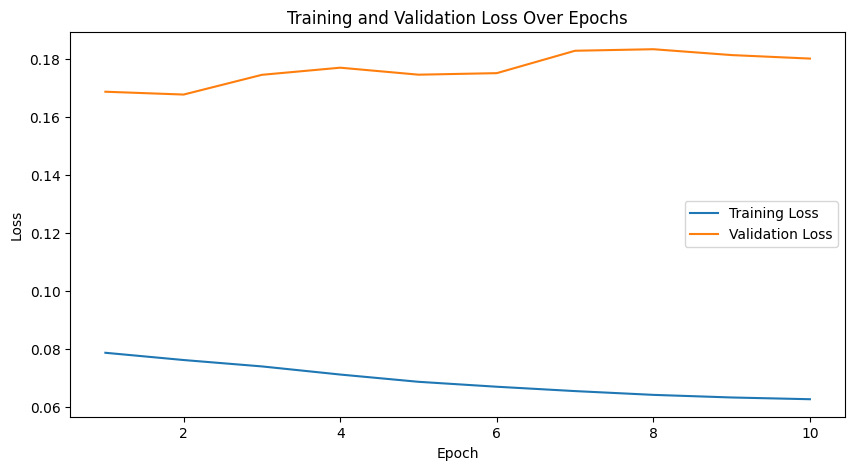

In [51]:
import matplotlib.pyplot as plt
log_history = trainer.state.log_history


epoch_list = []
train_loss_list = []
eval_loss_list = []


for log in log_history:
    if 'epoch' in log:
        epoch = log['epoch']
        if 'loss' in log:
            epoch_list.append(epoch)
            train_loss_list.append(log['loss'])
        if 'eval_loss' in log:
            if epoch not in epoch_list:
                epoch_list.append(epoch)
            eval_loss_list.append(log['eval_loss'])

# Eğitim ve doğrulama kayıplarını çiziyoruz
plt.figure(figsize=(10, 5))
if train_loss_list:
    plt.plot(epoch_list[:len(train_loss_list)], train_loss_list, label='Training Loss')
if eval_loss_list:
    plt.plot(epoch_list[:len(eval_loss_list)], eval_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()